# Comparing GCN & GAT on Node Classification

We will be using **Cora**, a citation network dataset, to serve as an example:
- Nodes: scientific publications (papers)
- Edges: citation links between papers (if paper A cites paper B, there's an edge)
- Node Features: 1,433-dimensional bag-of-words feature vectors (word presence/absence in each paper)

In [19]:
# core torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader

# other stuff
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os

In [2]:
torch.manual_seed(42)
np.random.seed(42)

print("Loading Cora dataset...")
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Loading Cora dataset...
Dataset: Cora()
Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Graph Convolution Network (GCN)

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        return x

model = GCN(
    num_features=dataset.num_features,
    hidden_channels=16,
    num_classes=dataset.num_classes
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        
        train_correct = pred[data.train_mask] == data.y[data.train_mask]
        train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
        
        val_correct = pred[data.val_mask] == data.y[data.val_mask]
        val_acc = int(val_correct.sum()) / int(data.val_mask.sum())
        
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, val_acc, test_acc, pred

In [4]:
print("\nTraining GCN model...")
train_losses = []
val_accuracies = []

for epoch in tqdm(range(1, 501), desc="Training", unit="epoch"):
    loss = train()
    train_acc, val_acc, test_acc, _ = test()
    train_losses.append(loss)
    val_accuracies.append(val_acc)

train_acc, val_acc, test_acc, predictions = test()
print(f"\n{'='*60}")
print(f"Final Results:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"{'='*60}")


Training GCN model...


Training: 100%|██████████| 500/500 [00:07<00:00, 67.47epoch/s]


Final Results:
Train Accuracy: 0.8571
Validation Accuracy: 0.6980
Test Accuracy: 0.7380


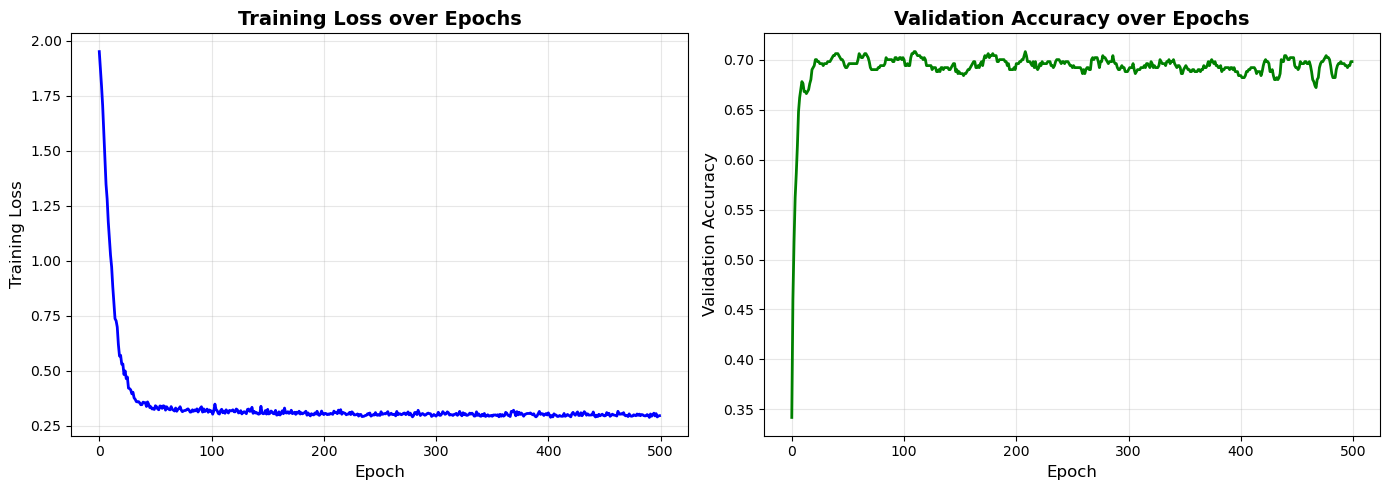

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, color='blue', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(val_accuracies, color='green', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Graph Attention Transformer (GAT)

In [6]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=8, dropout=0.6, attn_dropout=0.6):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=attn_dropout)
        self.conv2 = GATConv(hidden_channels * heads, num_classes, heads=1, concat=False, dropout=attn_dropout)
    
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        
        return x

model = GAT(
    num_features=dataset.num_features,
    hidden_channels=16,
    num_classes=dataset.num_classes,
    heads=8,
    dropout=0.6,
    attn_dropout=0.6
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss.item()

def test():
    model.eval()
    
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        train_correct = pred[data.train_mask] == data.y[data.train_mask]
        train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
        val_correct = pred[data.val_mask] == data.y[data.val_mask]
        val_acc = int(val_correct.sum()) / int(data.val_mask.sum())
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    
    return train_acc, val_acc, test_acc, pred

In [7]:
print("\nTraining GAT model...")
train_losses = []
val_accuracies = []

for epoch in tqdm(range(1, 501), desc="Training", unit="epoch"):
    loss = train()
    train_acc, val_acc, test_acc, _ = test()
    train_losses.append(loss)
    val_accuracies.append(val_acc)

train_acc, val_acc, test_acc, predictions = test()
print(f"\n{'='*60}")
print(f"Final Results:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"{'='*60}")


Training GAT model...


Training: 100%|██████████| 500/500 [00:33<00:00, 15.09epoch/s]


Final Results:
Train Accuracy: 1.0000
Validation Accuracy: 0.7580
Test Accuracy: 0.7920


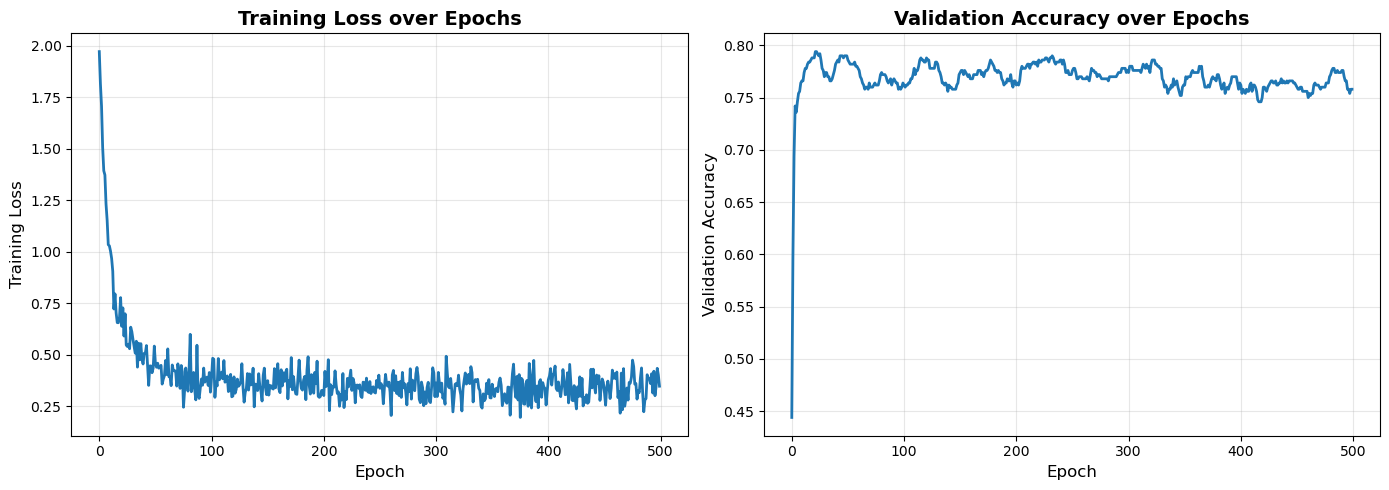

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(val_accuracies, linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparing Performance When Layer Increase

Model details:

- Deep Graph Convolutional Network (Deep GCN):
    - Conv + ReLU
    - Dropout layer
    - Weight decay
    - Last layer aggregation

- Deep Graph Attention Transformer (Deep GAT)
    - Mutihead Attention + LeakyReLU
    - Residual + Batchnorm / Layernorm
    - Dropout layer
    - Weight decay
    - Last layer aggregation instead of concatenation

In [16]:
class GCNDeep(nn.Module):
    """Deep GCN with variable number of layers.
    Follow implementation in the GCN (Conv + ReLU) paper but with dropout"""
    
    def __init__(self, num_features, hidden_channels, num_classes, num_layers):
        super().__init__()
        self.num_layers = num_layers
        if num_layers == 1:
            self.out = GCNConv(num_features, num_classes)
            self.layers = nn.ModuleList()
        else:
            self.layers = nn.ModuleList()
            self.layers.append(GCNConv(num_features, hidden_channels))
            for _ in range(num_layers - 2):
                self.layers.append(GCNConv(hidden_channels, hidden_channels))
            self.out = GCNConv(hidden_channels, num_classes)
    
    def forward(self, x, edge_index, dropout=0.5):
        if self.num_layers == 1:
            return self.out(x, edge_index)
        for conv in self.layers:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=dropout, training=self.training)
        x = self.out(x, edge_index)
        return x

class GATDeep(nn.Module):
    """Deep GAT with variable number of layers.
    Follow implementation in the GAT paper (Multihead Attention + LeakyReLU + Residual + Batchnorm) but with dropout"""
    
    def __init__(self, num_features, hidden_channels, num_classes, num_layers,
                 heads=8, dropout=0.6, attn_dropout=0.6, norm_type="layer"):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.norm_type = norm_type.lower()
        h_per_head = max(1, hidden_channels // heads)
        hidden_dim = h_per_head * heads

        if num_layers == 1:
            self.out = GATConv(num_features, num_classes, heads=1, concat=False, dropout=attn_dropout)
            self.layers, self.norms, self.in_proj = nn.ModuleList(), nn.ModuleList(), None
        else:
            self.layers = nn.ModuleList()
            self.norms = nn.ModuleList()
            self.layers.append(GATConv(num_features, h_per_head, heads=heads, dropout=attn_dropout))
            for _ in range(num_layers - 2):
                self.layers.append(GATConv(hidden_dim, h_per_head, heads=heads, dropout=attn_dropout))
            self.out = GATConv(hidden_dim, num_classes, heads=1, concat=False, dropout=attn_dropout)
            self.in_proj = nn.Linear(num_features, hidden_dim, bias=False)

            for _ in range(num_layers - 1):
                if self.norm_type == "batch":
                    self.norms.append(nn.BatchNorm1d(hidden_dim))
                elif self.norm_type == "layer":
                    self.norms.append(nn.LayerNorm(hidden_dim))
                else:
                    raise ValueError("norm_type must be 'batch' or 'layer'")

    def forward(self, x, edge_index):
        if self.num_layers == 1:
            x = F.dropout(x, p=self.dropout, training=self.training)
            return self.out(x, edge_index)

        x = F.dropout(x, p=self.dropout, training=self.training)
        for i, (conv, norm) in enumerate(zip(self.layers, self.norms)):
            h = conv(x, edge_index)
            h = norm(h)
            h = F.elu(h)
            if i == 0:
                x = h + self.in_proj(x)
            else:
                x = h + x
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.out(x, edge_index)
        return x

In [29]:
def train(model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test(model):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean().item()
        val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean().item()
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()
    return train_acc, val_acc, test_acc, pred


def run_depth_sweep(model_type,
                    layer_list,
                    epochs=300,
                    lr=0.005,
                    weight_decay=5e-4,
                    hidden=16,
                    save_dir="saved_models"):
    
    os.makedirs(save_dir, exist_ok=True)
    results = []
    for L in layer_list:
        if model_type == "GCN":
            model = GCNDeep(dataset.num_features, hidden, dataset.num_classes, num_layers=L)
        else:
            model = GATDeep(dataset.num_features, hidden, dataset.num_classes, num_layers=L, heads=8, dropout=0.6, attn_dropout=0.6)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        best_val, best_test = -1.0, 0.0
        best_pred = None
        best_path = os.path.join(save_dir, f"{model_type}_L{L}.pt")

        for _ in tqdm(range(epochs), desc=f"{model_type} L={L}", leave=False):
            train(model, optimizer, criterion)
            _, val_acc, test_acc, pred = test(model)
            if val_acc > best_val:
                best_val = val_acc
                best_test = test_acc
                best_pred = pred.clone()
                torch.save(model.state_dict(), best_path)
        results.append((L, best_test, best_pred, best_path))
    return results

layers_to_try = [1, 2, 3, 4]
gcn_results = run_depth_sweep("GCN", layers_to_try, epochs=500, lr=0.01, weight_decay=5e-4)
gat_results = run_depth_sweep("GAT", layers_to_try, epochs=500, lr=0.01, weight_decay=5e-4)

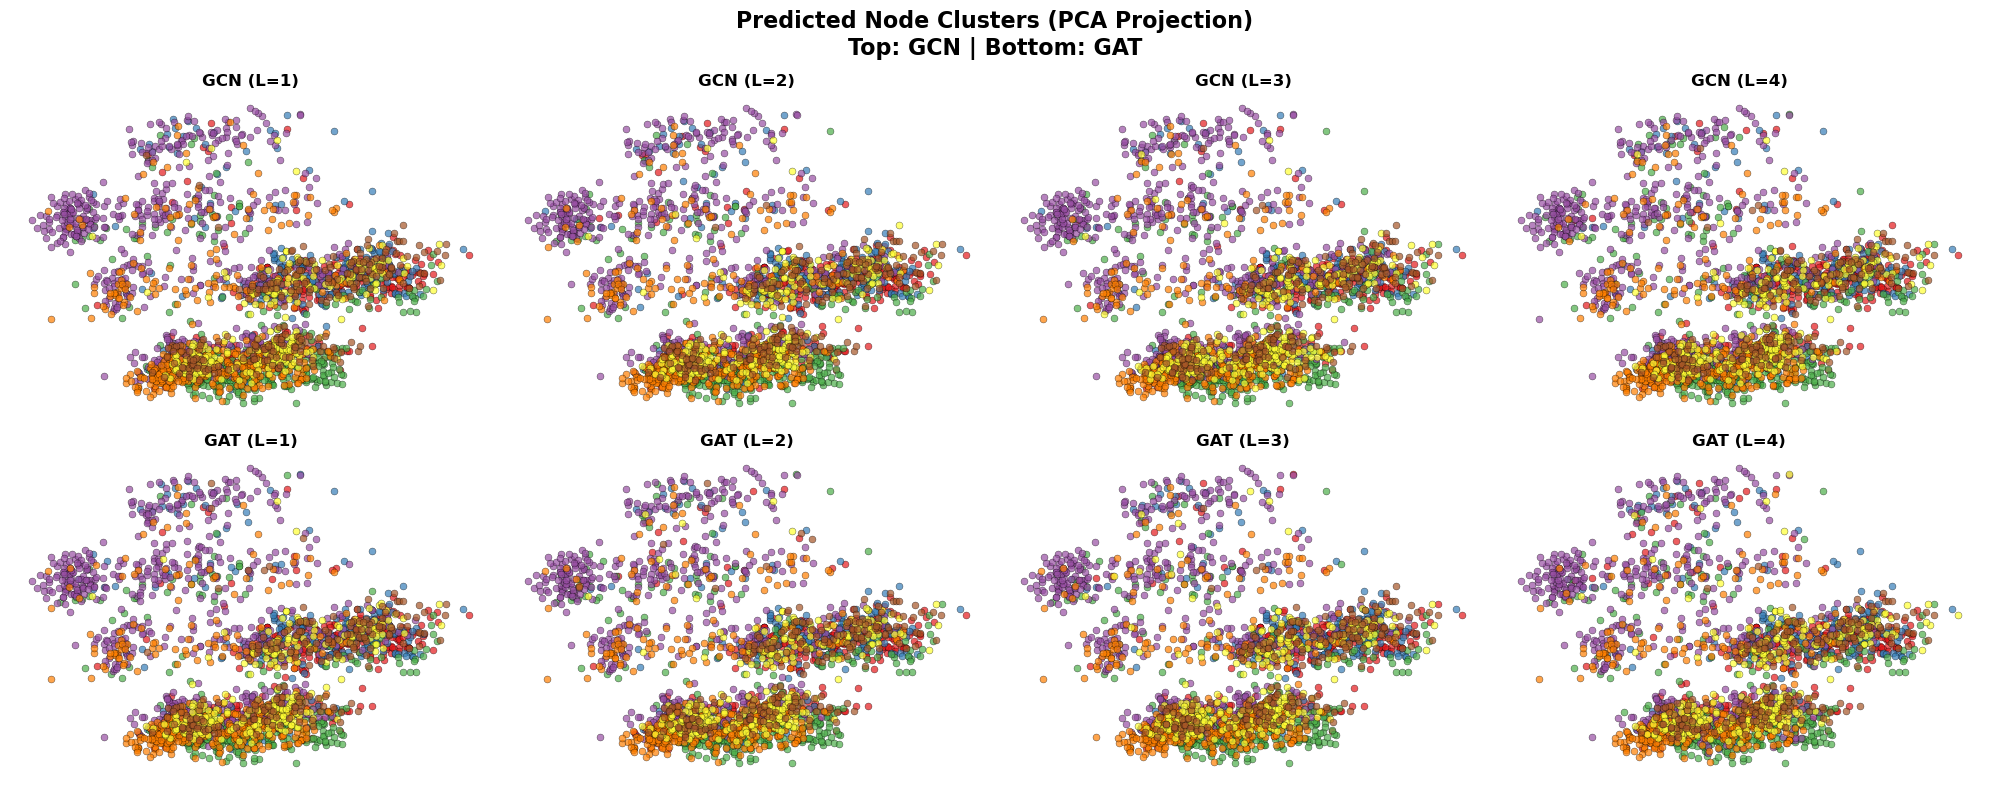

In [30]:
def plot_predictions_grid(model_type, results, dataset, data, colors, row_idx, fig, use_hidden=False):
    n_cols = len(results)
    for j, (L, _, _, path) in enumerate(results):
        if model_type == "GCN":
            model = GCNDeep(dataset.num_features, 16, dataset.num_classes, num_layers=L)
        else:
            model = GATDeep(dataset.num_features, 16, dataset.num_classes, num_layers=L, heads=8, dropout=0.6, attn_dropout=0.6)
        model.load_state_dict(torch.load(path))
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1).cpu().numpy()

        node_embeddings = data.x.cpu().numpy()
        pca = PCA(n_components=2, random_state=42)
        pos = pca.fit_transform(node_embeddings)

        ax = fig.axes[row_idx * n_cols + j]
        for class_id in range(dataset.num_classes):
            nodes = np.where(pred == class_id)[0]
            coords = pos[nodes]
            ax.scatter(coords[:, 0], coords[:, 1],
                       c=colors[class_id], s=25, alpha=0.7, edgecolors='black', linewidth=0.3)
        ax.set_title(f"{model_type} (L={L})", fontsize=12, fontweight='bold')
        ax.axis('off')

fig, axes = plt.subplots(2, len(layers_to_try), figsize=(5 * len(layers_to_try), 8))
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628'][:dataset.num_classes]

plot_predictions_grid("GCN", gcn_results, dataset, data, colors, row_idx=0, fig=fig)
plot_predictions_grid("GAT", gat_results, dataset, data, colors, row_idx=1, fig=fig)

fig.suptitle("Predicted Node Clusters (PCA Projection)\nTop: GCN | Bottom: GAT", fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

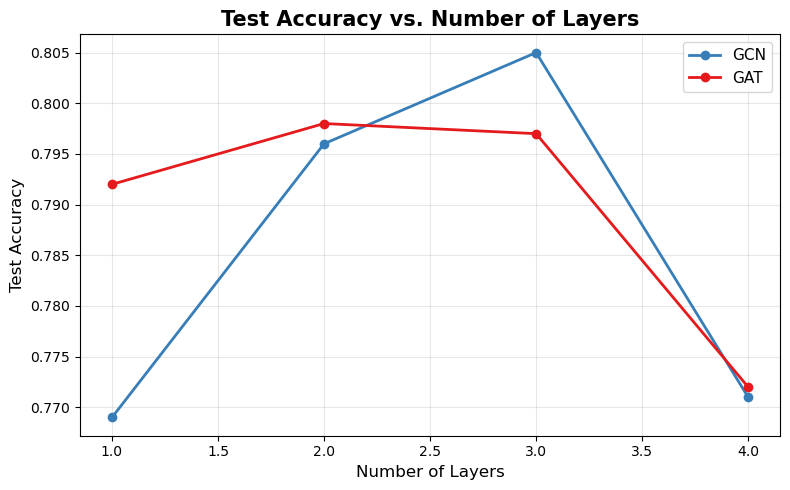

In [31]:
x_gcn = [L for L, _, _, _ in gcn_results]
y_gcn = [acc for _, acc, _, _ in gcn_results]

x_gat = [L for L, _, _, _ in gat_results]
y_gat = [acc for _, acc, _, _ in gat_results]

plt.figure(figsize=(8, 5))
plt.plot(x_gcn, y_gcn, marker='o', linewidth=2, label='GCN', color='#377eb8')
plt.plot(x_gat, y_gat, marker='o', linewidth=2, label='GAT', color='#e41a1c')
plt.title("Test Accuracy vs. Number of Layers", fontsize=15, fontweight='bold')
plt.xlabel("Number of Layers", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

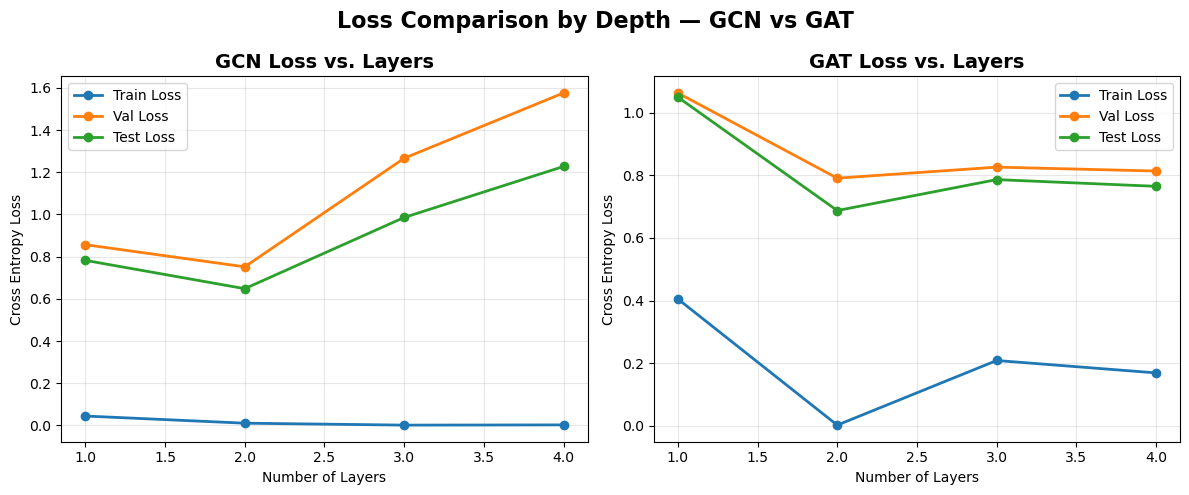

In [32]:
def compute_loss_curve(model_type, layer_list, dataset, data, hidden=16, save_dir="saved_models"):
    criterion = torch.nn.CrossEntropyLoss()
    losses = {}
    for L in layer_list:
        if model_type == "GCN":
            model = GCNDeep(dataset.num_features, hidden, dataset.num_classes, num_layers=L)
        else:
            model = GATDeep(dataset.num_features, hidden, dataset.num_classes,
                            num_layers=L, heads=8, dropout=0.6, attn_dropout=0.6)

        path = os.path.join(save_dir, f"{model_type}_L{L}.pt")
        if not os.path.exists(path):
            print(f"{path} not found, skipping.")
            continue

        model.load_state_dict(torch.load(path))
        model.eval()

        with torch.no_grad():
            out = model(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask]).item()
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()
            test_loss = criterion(out[data.test_mask], data.y[data.test_mask]).item()

        losses[L] = {"train": loss, "val": val_loss, "test": test_loss}
    return losses

layers_to_try = [1, 2, 3, 4]
gcn_losses = compute_loss_curve("GCN", layers_to_try, dataset, data)
gat_losses = compute_loss_curve("GAT", layers_to_try, dataset, data)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x = list(gcn_losses.keys())
train = [gcn_losses[L]["train"] for L in x]
val = [gcn_losses[L]["val"] for L in x]
test = [gcn_losses[L]["test"] for L in x]
axes[0].plot(x, train, '-o', label="Train Loss", linewidth=2)
axes[0].plot(x, val, '-o', label="Val Loss", linewidth=2)
axes[0].plot(x, test, '-o', label="Test Loss", linewidth=2)
axes[0].set_title("GCN Loss vs. Layers", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Number of Layers"); axes[0].set_ylabel("Cross Entropy Loss")
axes[0].grid(True, alpha=0.3); axes[0].legend()

x = list(gat_losses.keys())
train = [gat_losses[L]["train"] for L in x]
val = [gat_losses[L]["val"] for L in x]
test = [gat_losses[L]["test"] for L in x]
axes[1].plot(x, train, '-o', label="Train Loss", linewidth=2)
axes[1].plot(x, val, '-o', label="Val Loss", linewidth=2)
axes[1].plot(x, test, '-o', label="Test Loss", linewidth=2)
axes[1].set_title("GAT Loss vs. Layers", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Number of Layers"); axes[1].set_ylabel("Cross Entropy Loss")
axes[1].grid(True, alpha=0.3); axes[1].legend()

plt.suptitle("Loss Comparison by Depth — GCN vs GAT", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---